<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

import warnings
warnings.filterwarnings("ignore")

2023-12-07 23:29:42.168046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 23:29:42.168089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 23:29:42.168113: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 23:29:42.174215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


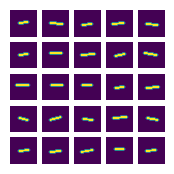

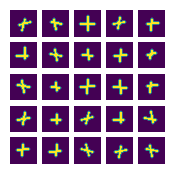

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2))  # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)  # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)  # -||-

    for i in range(number_of_images):  # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i, 0]), (y2[i], x[i, 1]), (255, 0, 0), 2,
                 cv2.LINE_AA)  # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i, 0], y1[i]), (x[i, 1], y2[i]), (255, 0, 0), 2,
                     cv2.LINE_AA)  # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i, 0], y1[i]), (x[i, 1], y2[i]), (255, 0, 0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i, 0], y1[i]), (x[i, 1], y2[i]), (255, 0, 0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i, 0], y1[i]), (x[i, 1], y2[i]), (255, 0, 0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n ** 2):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()


show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-'], max_answer_length=3):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation (7 )
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28) -> sequence of 7 images of size 28x28
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels == x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):  # First addend
        for j in range(highest_integer + 1):  # Second addend
            # for k in range(highest_integer + 1):  # Third addend
            # i_char = to_padded_chars(i, max_len=max_int_length) # convert integers to strings of constant length [20->' 20']
            # j_char = to_padded_chars(j, max_len=max_int_length, pad_right=True)
            # k_char = to_padded_chars(k, max_len=max_int_length, pad_right=True)

            for sign in operands:  # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img) / 255., np.stack(y_text), np.stack(y_img) / 255.


def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 7: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #6685

X_text: "33-42" = y_text: "-9 "


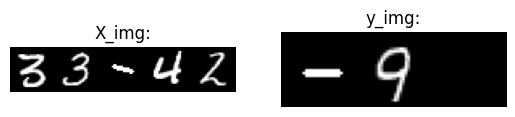

Query #6617

X_text: "33-8 " = y_text: "25 "


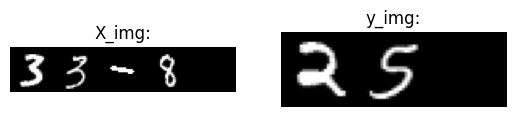

Query #2059

X_text: "10-29" = y_text: "-19"


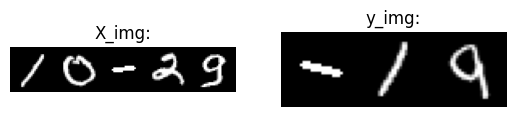

Query #2355

X_text: "11-77" = y_text: "-66"


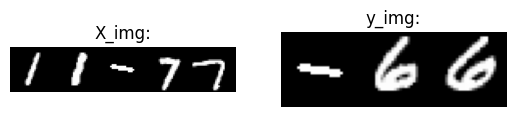

Query #5190

X_text: "25+95" = y_text: "120"


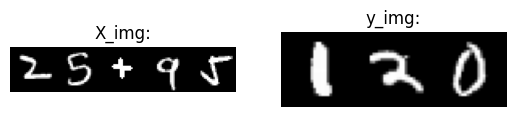

Query #4533

X_text: "22-66" = y_text: "-44"


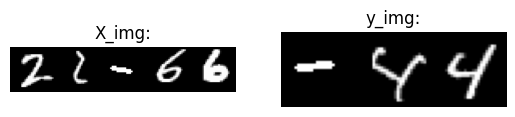

Query #8856

X_text: "44+28" = y_text: "72 "


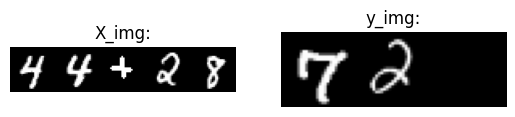

Query #8450

X_text: "42+25" = y_text: "67 "


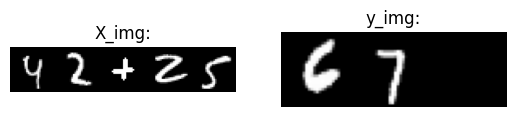

Query #4186

X_text: "20+93" = y_text: "113"


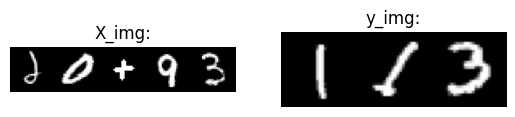

Query #9187

X_text: "45-93" = y_text: "-48"


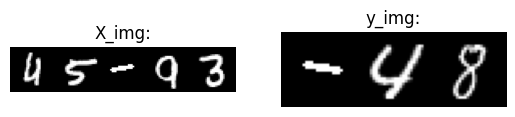

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '  # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99  # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1  # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3  # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1, 2, i + 1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('=' * 50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()


for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, unique_characters=unique_characters, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot


def decode_labels(labels, unique_characters=unique_characters):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted


X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [45]:
def build_text2text_model(max_answer_length=3, unique_characters=unique_characters):
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [46]:
def is_int(str_: str):
    try:
        int(str_)
        return True
    except:
        return False


def build_data_fit_model(X_text, y_text, test_split_size, max_answer_length=3, epochs=30):
    text_model = build_text2text_model(max_answer_length=max_answer_length)
    X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=test_split_size, random_state=42)

    text_model.fit(X_train_text, y_train_text, epochs=epochs)

    return text_model, X_train_text, X_test_text, y_train_text, y_test_text


def evaluate_model(text_model, X_test, y_test, test_split_size):
    _, y_test_acc = text_model.evaluate(X_test, y_test)
    y_test_pred = text_model.predict(X_test)

    pred_true_diff = []
    no_number_output = 0
    for y_pred_item, y_true_item in zip(y_test_pred, y_test):
        pred, true = decode_labels(y_pred_item), decode_labels(y_true_item)
        pred = pred.replace(" ", "")
        true = true.replace(" ", "")
        if pred != true:
            if is_int(pred):
                pred = int(pred)
                true = int(true)
                pred_true_diff.append(true - pred)
            else:
                no_number_output += 1

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Difference Plot of Test Split Size {test_split_size}, Accuracy on Test Set:{round(y_test_acc, 3)}, No Number Outputs Propoertion:{round(no_number_output / len(y_test_pred), 3)}")

    plt.subplot(1, 3, 1)
    plt.boxplot(pred_true_diff)
    plt.title("Boxplot Before Outlier Removal")
    plt.ylabel("Difference of True Value and Prediction")
    
    
    Q1 = np.percentile(pred_true_diff, 25, method='midpoint')
    Q3 = np.percentile(pred_true_diff, 75, method='midpoint')
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    no_outlier = [val for val in pred_true_diff if lower <= val <= upper ]
    
    plt.subplot(1, 3, 2)
    plt.hist(x=no_outlier)
    plt.title("Histogram After Outlier Removal")
    plt.xlabel("Difference Values")
    
    plt.subplot(1, 3, 3)
    plt.boxplot(no_outlier)
    plt.title("Boxplot After Outlier Removal")
    plt.ylabel("Difference between True Value and Prediction")
    
    plt.show();


def build_model_evaluate(X_text, y_text, test_split_sizes, max_answer_length=3, epochs=30):
    for test_split_size in test_split_sizes:
        print(f"==================={test_split_size}===================")
        text_model, X_train_text, X_test_text, y_train_text, y_test_text = build_data_fit_model(
            X_text=X_text,
            y_text=y_text,
            test_split_size=test_split_size,
            max_answer_length=max_answer_length,
            epochs=epochs
        )

        evaluate_model(text_model=text_model, X_test=X_test_text, y_test=y_test_text, test_split_size=test_split_size)

===================0.25===================
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_11 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_23 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_11 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

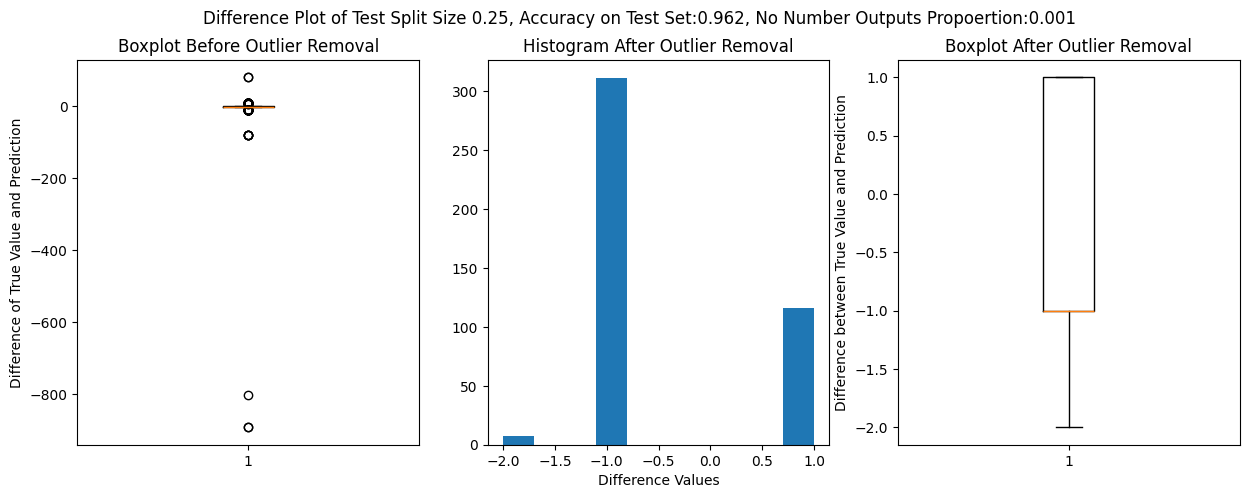

===================0.5===================
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_12 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_25 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_12 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

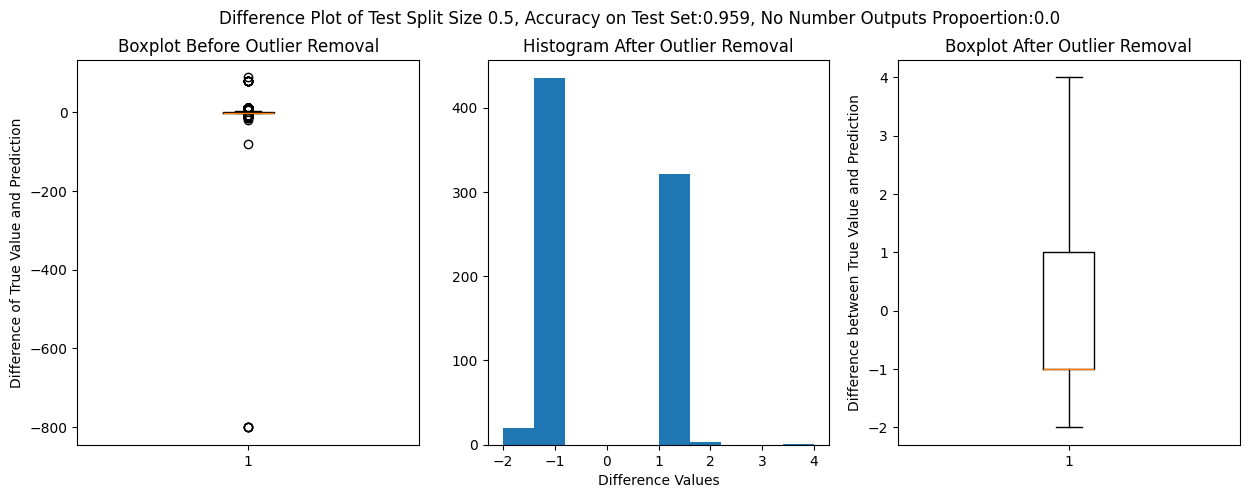

===================0.75===================
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_13 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_27 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_13 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

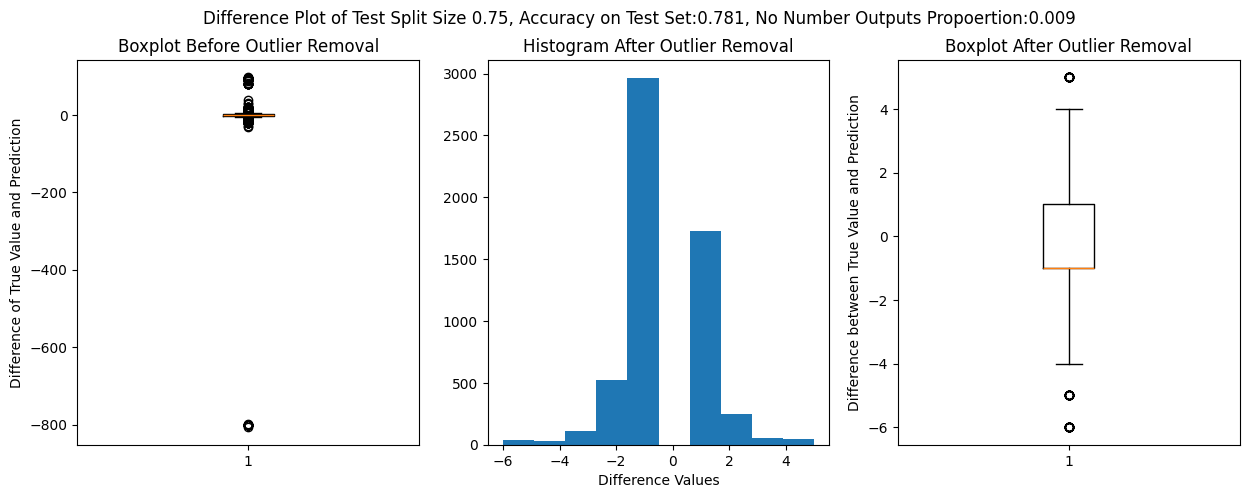

===================0.9===================
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_14 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_29 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_14 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

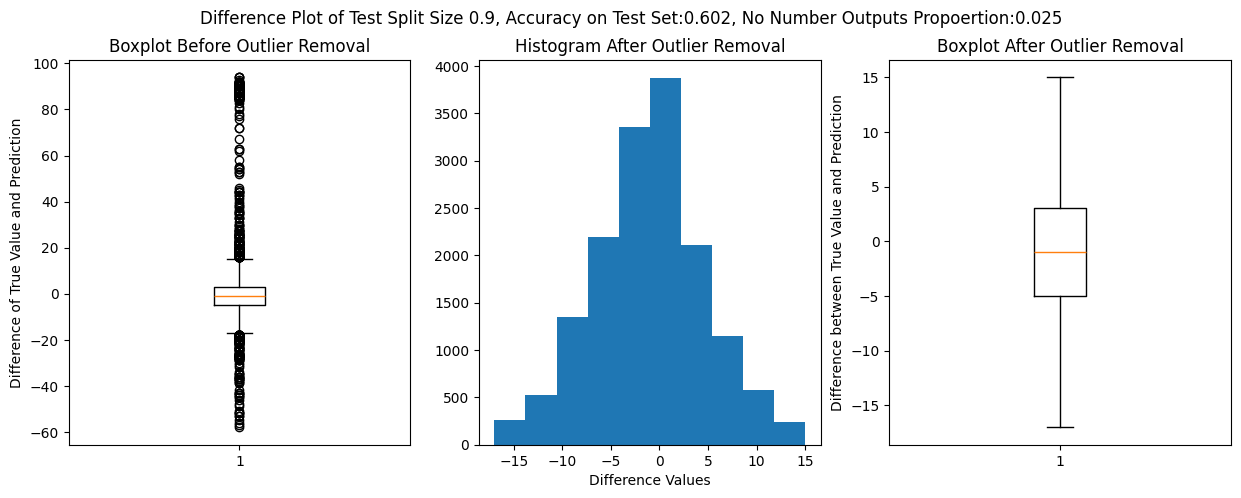

In [29]:
build_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_sizes=[0.25, 0.5, 0.75, 0.9], epochs=30)

# Build Heavier Model

In [47]:
def build_text2text_model_heavy(num_additional_layers, unique_characters=unique_characters, max_answer_length=3):
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    for i in range(num_additional_layers):
        if i == num_additional_layers - 1:
            return_sequences = False
        else:
            return_sequences = True
        text2text.add(LSTM(256, return_sequences=return_sequences))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [48]:
def build_data_fit_model_heavy(X_text, y_text, test_split_size, num_additional_layers, max_answer_length=3, epochs=30):
    text_model = build_text2text_model_heavy(num_additional_layers=num_additional_layers, max_answer_length=max_answer_length)
    X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=test_split_size, random_state=42)

    text_model.fit(X_train_text, y_train_text, epochs=epochs)

    return text_model, X_train_text, X_test_text, y_train_text, y_test_text


def build_heavy_model_evaluate(X_text, y_text, test_split_size, num_additional_layers, max_answer_length=3, epochs=30):
    text_model, X_train_text, X_test_text, y_train_text, y_test_text = build_data_fit_model_heavy(
        X_text=X_text,
        y_text=y_text,
        test_split_size=test_split_size,
        num_additional_layers=num_additional_layers,
        max_answer_length=max_answer_length,
        epochs=epochs
    )

    evaluate_model(text_model=text_model, X_test=X_test_text, y_test=y_test_text, test_split_size=test_split_size)

===================0.25===================
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_52 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_21 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_53 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_21 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total para

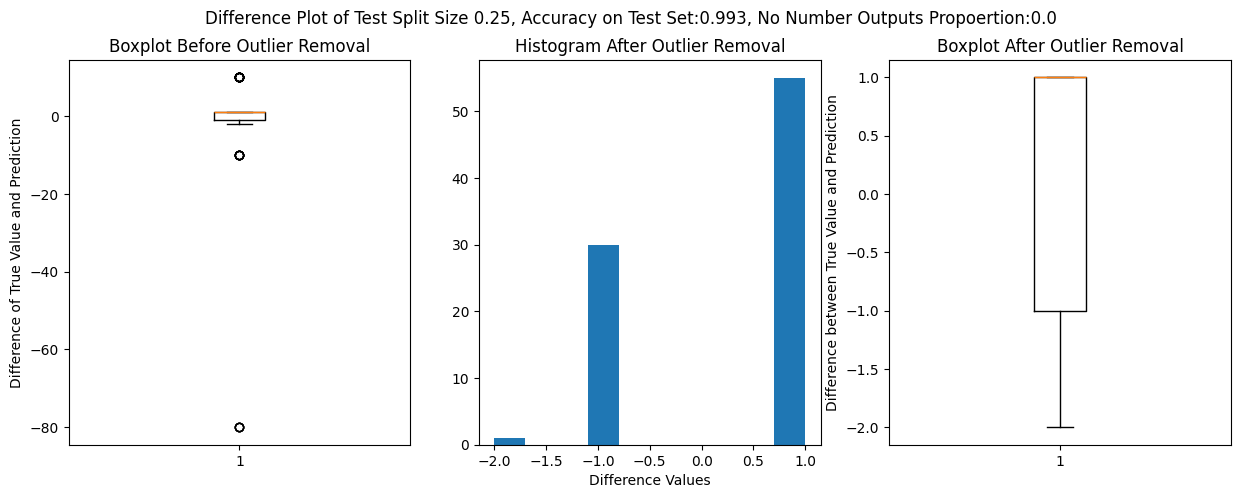

In [42]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=1, epochs=30)

===================0.25===================
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, None, 256)         276480    
                                                                 
 lstm_55 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_56 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_22 (RepeatVe  (None, 3, 256)            0         
 ctor)                                                           
                                                                 
 lstm_57 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_22 (TimeD  (None, 3, 13)             3341      
 istribute

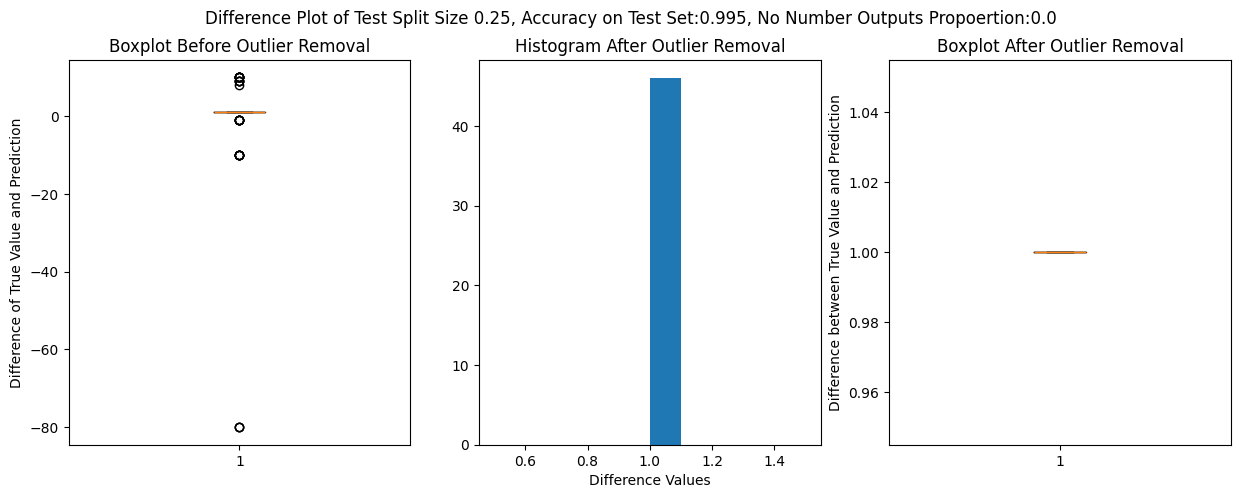

In [43]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=2, epochs=30)

---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #8108

X_text: "81*8 " = y_text: "648  "


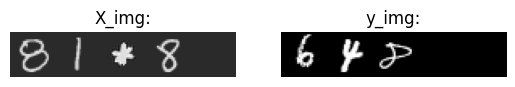

Query #1223

X_text: "12*23" = y_text: "276  "


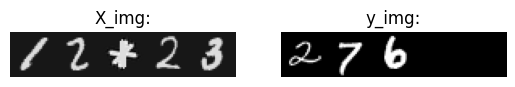

Query #7737

X_text: "77*37" = y_text: "2849 "


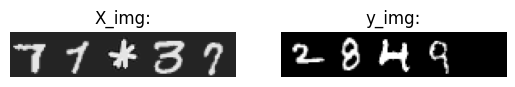

Query #2418

X_text: "24*18" = y_text: "432  "


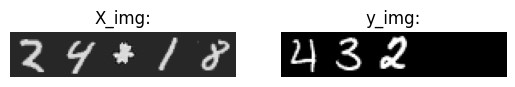

Query #2115

X_text: "21*15" = y_text: "315  "


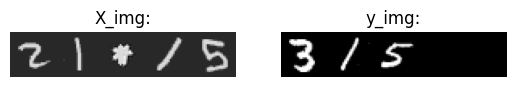

Query #249

X_text: "2*49 " = y_text: "98   "


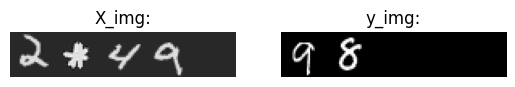

Query #9926

X_text: "99*26" = y_text: "2574 "


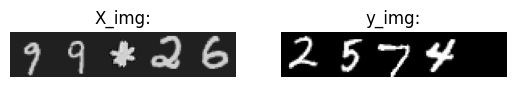

Query #9325

X_text: "93*25" = y_text: "2325 "


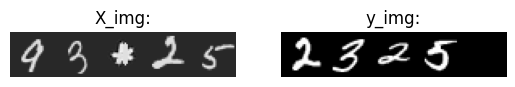

Query #4153

X_text: "41*53" = y_text: "2173 "


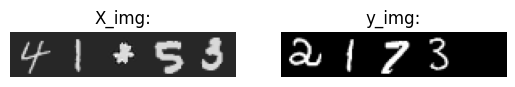

Query #2401

X_text: "24*1 " = y_text: "24   "


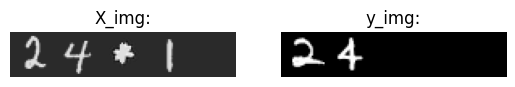

In [53]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [54]:
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(10000, 5, 12) (10000, 5, 12)


===================0.25===================
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_23 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_59 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_23 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

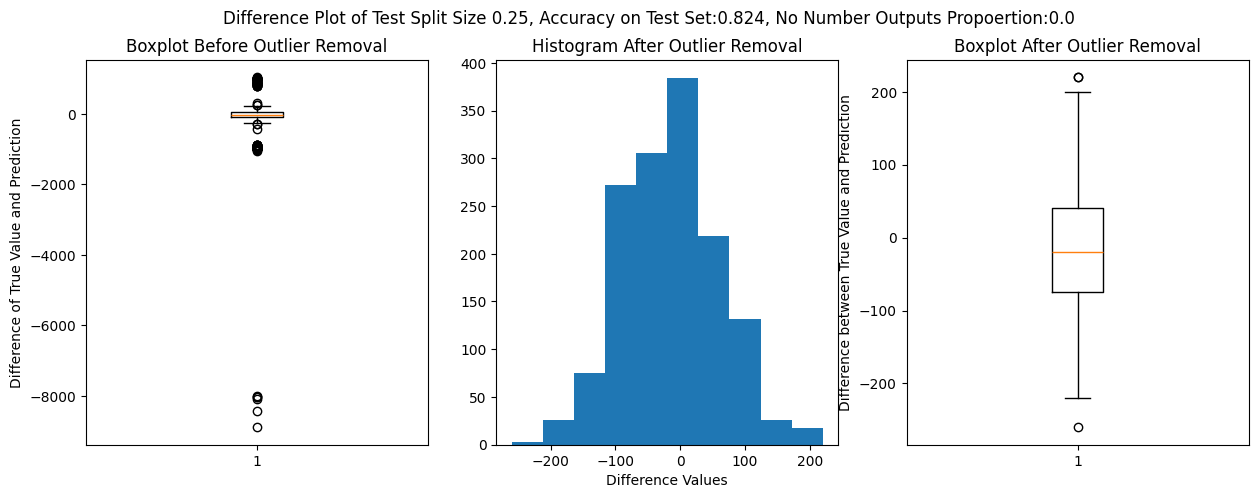

===================0.5===================
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_24 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_61 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_24 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

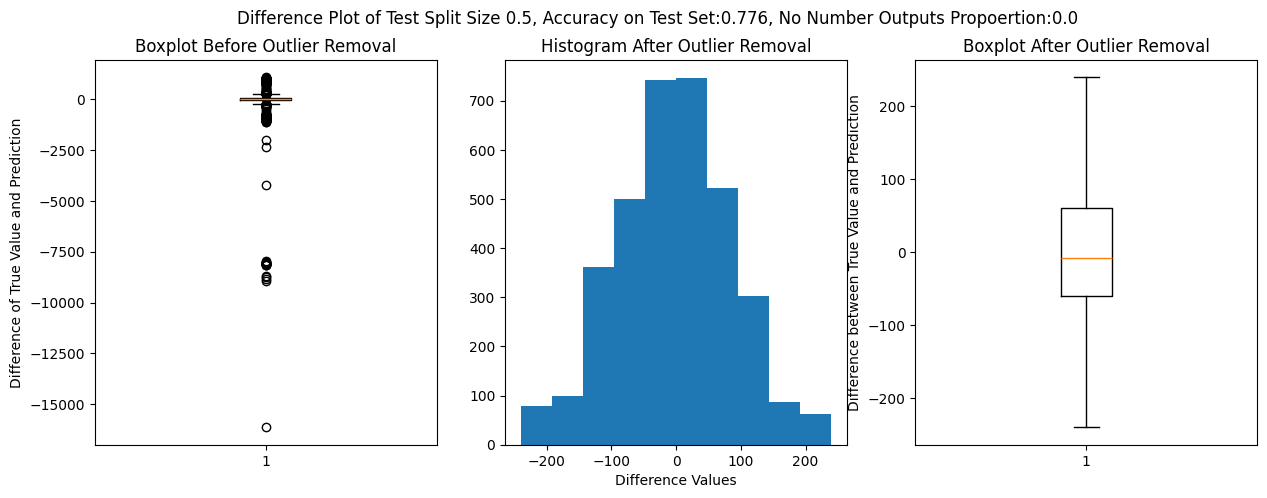

===================0.75===================
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_25 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_63 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_25 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

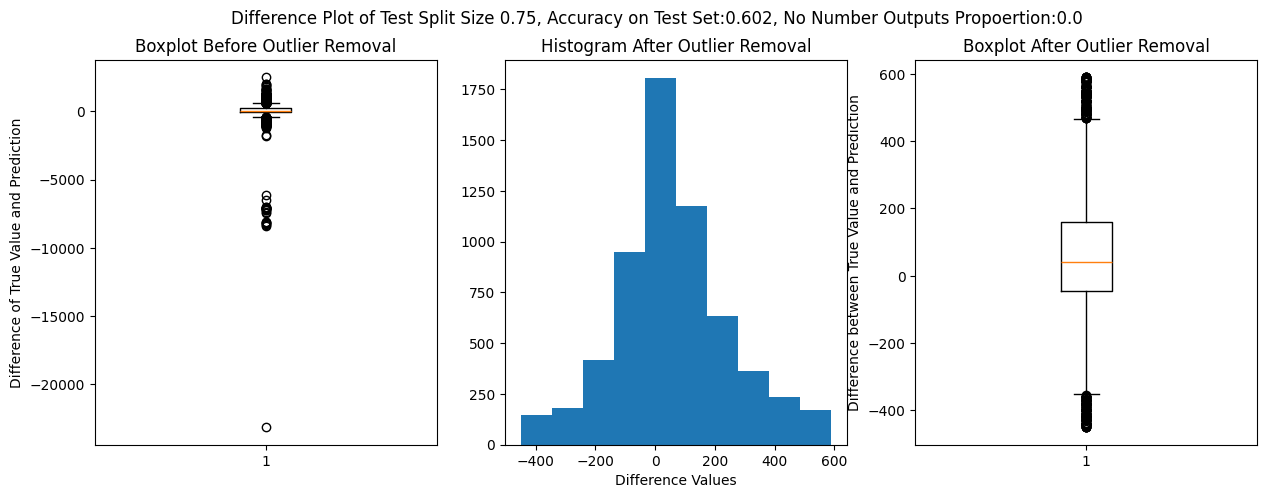

===================0.9===================
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 256)               275456    
                                                                 
 repeat_vector_26 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_65 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_26 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

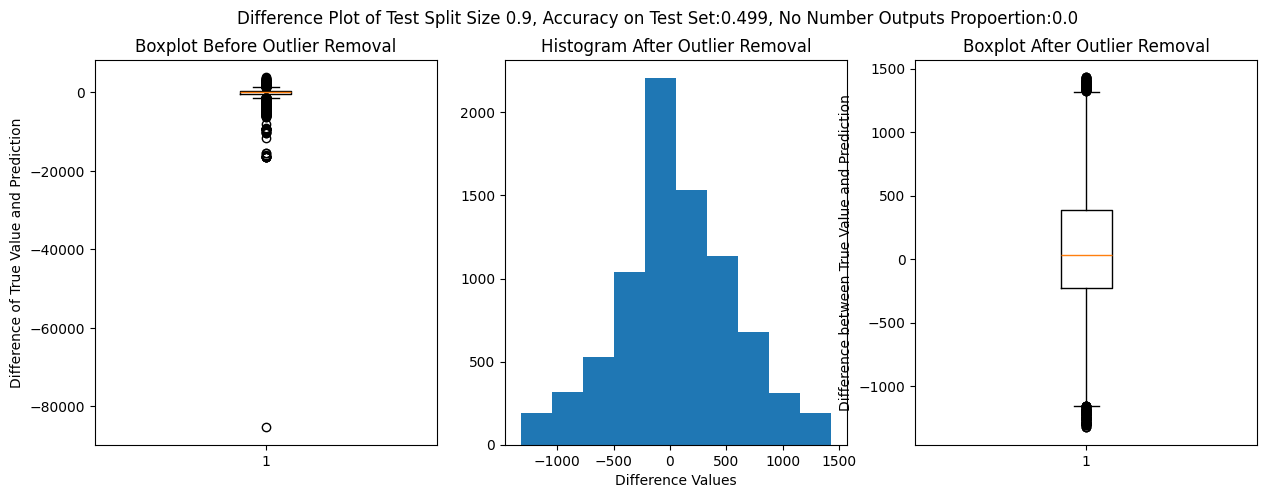

In [55]:
build_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_sizes=[0.25, 0.5, 0.75, 0.9], 
                     max_answer_length=max_answer_length, epochs=30)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_67 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_27 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_68 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_27 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 1329164 (5.07 MB)
Trainable params: 132

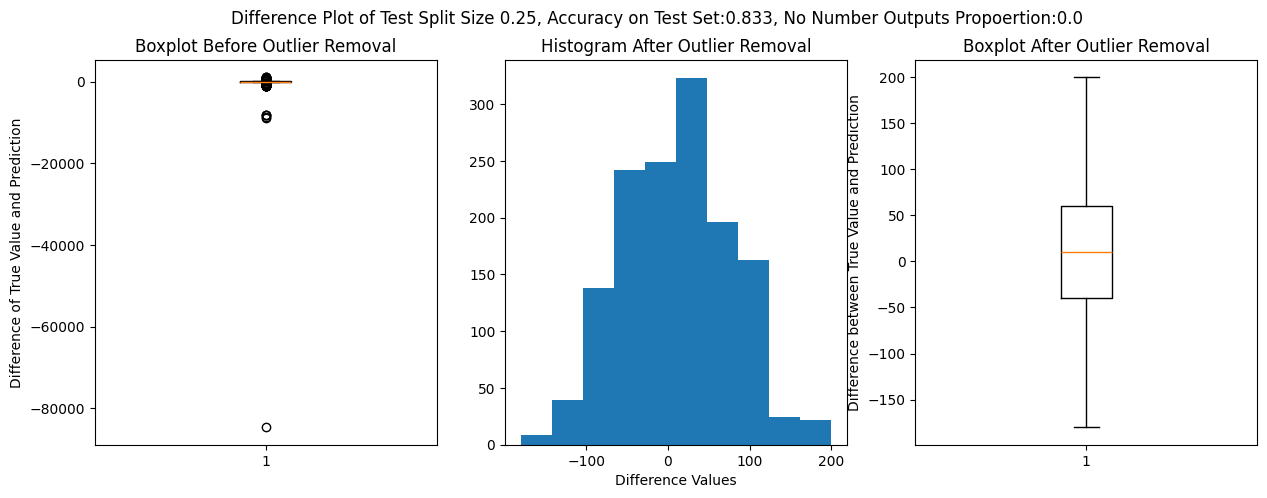

In [56]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=1, max_answer_length=max_answer_length, epochs=30)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_87 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_88 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_32 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_89 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_32 (TimeD  (None, 5, 12)             3084      
 istributed)                                                     
                                                                 
Total params: 1329164 (5.07 MB)
Trainable params: 132

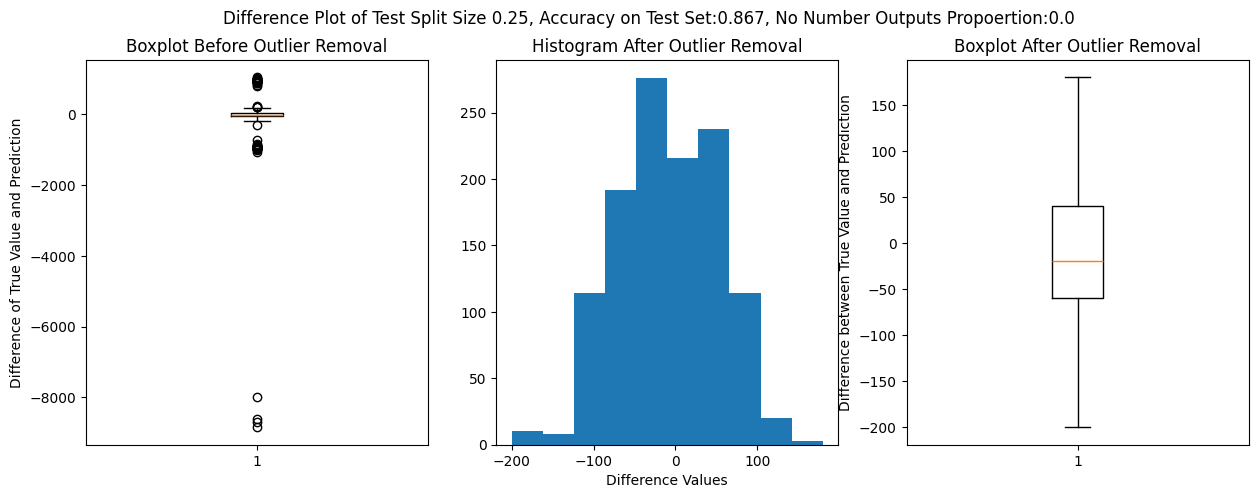

In [61]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=1, max_answer_length=max_answer_length, epochs=50)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_74 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_75 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_29 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_76 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_29 (TimeD  (None, 5, 12)             3084      
 istributed)                                         

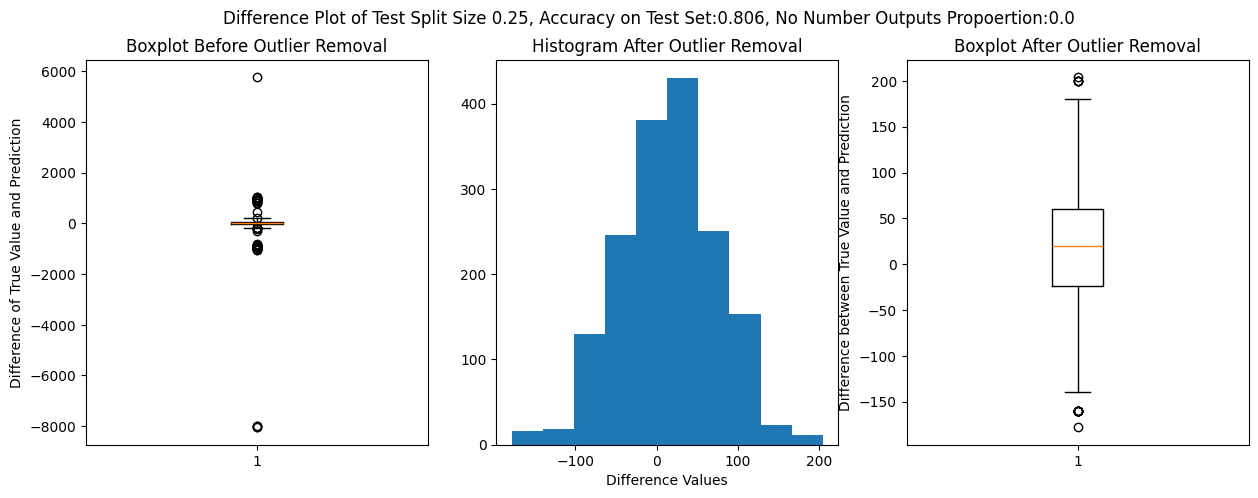

In [58]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=2, max_answer_length=max_answer_length, epochs=30)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_78 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_79 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_80 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_30 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_81 (LSTM)              (None, 5, 256)            525312    
                                                     

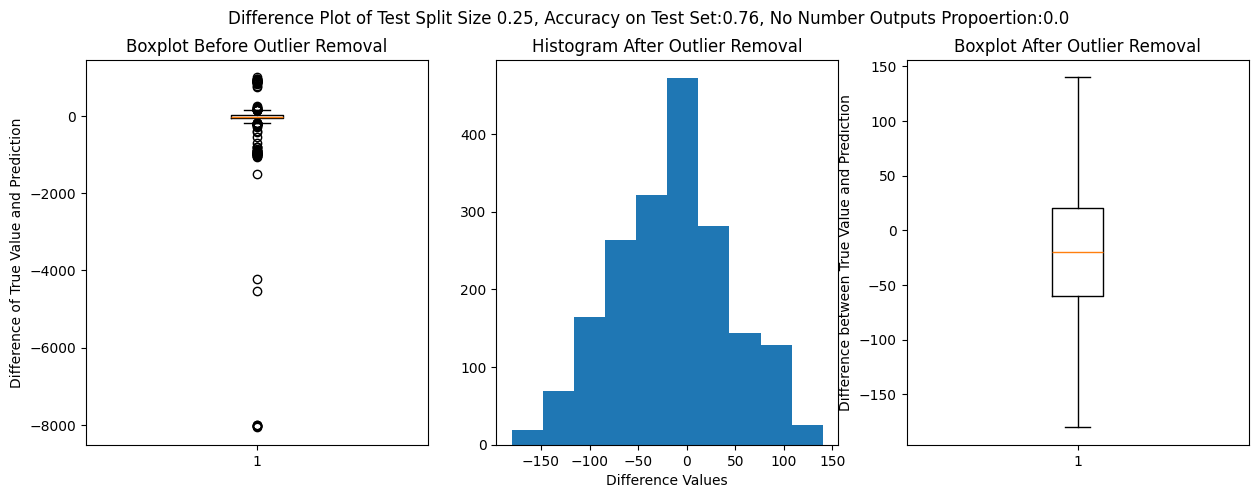

In [59]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=3, max_answer_length=max_answer_length, epochs=30)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, None, 256)         275456    
                                                                 
 lstm_83 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_84 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_85 (LSTM)              (None, 256)               525312    
                                                                 
 repeat_vector_31 (RepeatVe  (None, 5, 256)            0         
 ctor)                                                           
                                                                 
 lstm_86 (LSTM)              (None, 5, 256)            525312    
                                                     

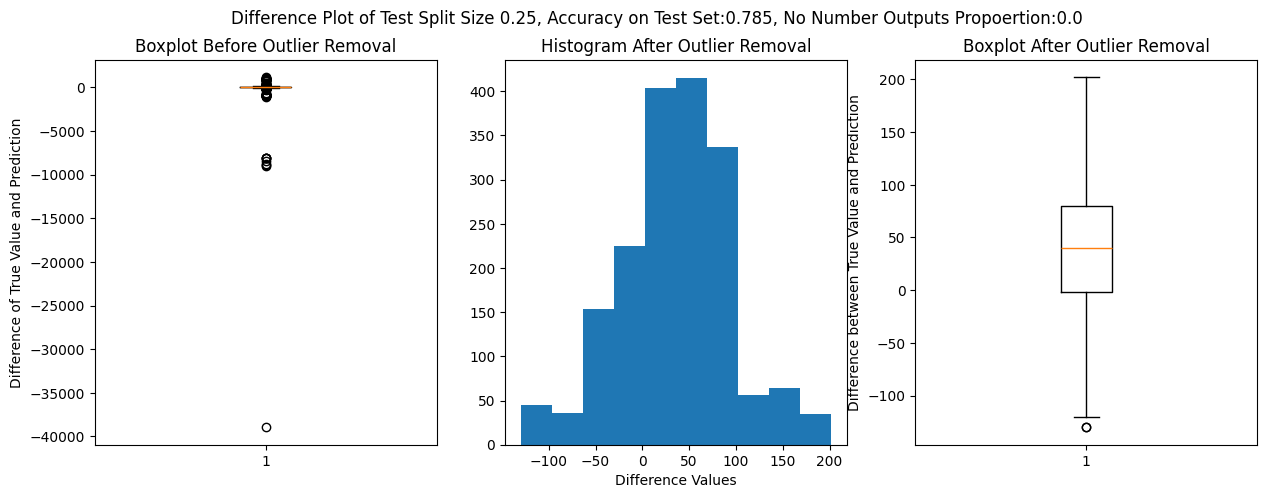

In [60]:
build_heavy_model_evaluate(X_text=X_text_onehot, y_text=y_text_onehot, test_split_size=0.25, num_additional_layers=3, max_answer_length=max_answer_length, epochs=50)